# E-commerce Sales Prediction - Exploratory Data Analysis

This notebook contains comprehensive exploratory data analysis for the e-commerce sales prediction project. We'll analyze various aspects of the data to understand patterns and relationships that can help in predicting weekly sales.

## Setup and Data Loading

In [1]:
!pip install pyspark
!pip install findspark
!pip install seaborn

In [33]:
!brew install git-lfs
!git lfs install
!sudo chmod -R 777 /workspace/big-data/.git/lfs/
!git lfs pull


To reinstall 3.6.1, run:
  brew reinstall git-lfs
Updated Git hooks.
Git LFS initialized.


In [4]:
# Import required libraries
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, count, mean, stddev
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Import project utilities
import sys
sys.path.append('../src')

# Set up plotting style
plt.style.use('ggplot')
sns.set_palette('husl')

In [5]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("SalesPrediction_EDA") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv('../data/raw/BaSalam.products.csv', header=True, inferSchema=True)

# Display basic information
print("Dataset Overview:")
print(f"Number of records: {df.count():,}")
print(f"Number of features: {len(df.columns)}")
print("\nSchema:")
df.printSchema()

Picked up JAVA_TOOL_OPTIONS: -XX:+UseContainerSupport -XX:ActiveProcessorCount=1
Picked up JAVA_TOOL_OPTIONS: -XX:+UseContainerSupport -XX:ActiveProcessorCount=1
25/04/16 21:57:19 WARN Utils: Your hostname, moucode-bigdata-2hhhsf746iu resolves to a loopback address: 127.0.0.1; using 10.0.5.2 instead (on interface eth0)
25/04/16 21:57:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 21:57:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Dataset Overview:


Number of records: 2,411,358
Number of features: 43

Schema:
root
 |-- _id: integer (nullable = true)
 |-- _score: double (nullable = true)
 |-- sales_count_week: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- status_id: integer (nullable = true)
 |-- status_title: string (nullable = true)
 |-- stock: integer (nullable = true)
 |-- photo_MEDIUM: string (nullable = true)
 |-- photo_SMALL: string (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- rating_count: integer (nullable = true)
 |-- rating_signals: integer (nullable = true)
 |-- primaryPrice: integer (nullable = true)
 |-- preparationDays: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- has_delivery: boolean (nullable = true)
 |-- has_variation: boolean (nullable = true)
 |-- new_categoryId: integer (nullable = true)
 |-- navigation_id: integer (nullable = true)
 |-- vendor_name: string (nul

## Helper Functions

In [6]:
"""
Utility functions for the sales prediction project.
"""

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, mean, stddev
import numpy as np
import pandas as pd


def plot_missing_values(df):
    """
    Plot missing values analysis.
    
    Args:
        df: Spark DataFrame
    """
    total_count = df.count()
    missing_counts = []
    
    for column in df.columns:
        missing_count = df.filter(col(column).isNull()).count()
        missing_percentage = (missing_count / total_count) * 100
        missing_counts.append({
            'column': column,
            'missing_percentage': missing_percentage
        })
    
    missing_df = pd.DataFrame(missing_counts)
    missing_df = missing_df.sort_values('missing_percentage', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(missing_df['column'], missing_df['missing_percentage'])
    plt.xlabel('Missing Percentage')
    plt.title('Missing Values Analysis')
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, columns):
    """
    Plot correlation matrix for specified columns.
    
    Args:
        df: Spark DataFrame
        columns: List of column names to include in correlation matrix
    """
    correlation_data = df.select(columns).toPandas()
    correlation_matrix = correlation_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

def detect_outliers(df, column, threshold=3):
    """
    Detect outliers using z-score method.
    
    Args:
        df: Spark DataFrame
        column: Column name to check for outliers
        threshold: Z-score threshold for outlier detection
        
    Returns:
        DataFrame: DataFrame with outlier indicators
    """
    stats = df.select(
        mean(col(column)).alias('mean'),
        stddev(col(column)).alias('stddev')
    ).collect()[0]
    
    mean_val = stats['mean']
    stddev_val = stats['stddev']
    
    return df.withColumn(
        f'{column}_zscore',
        (col(column) - mean_val) / stddev_val
    ).withColumn(
        f'{column}_is_outlier',
        (col(f'{column}_zscore').abs() > threshold)
    )

def evaluate_regression_model(predictions, label_col="label", prediction_col="prediction"):
    """
    Evaluate regression model performance.
    
    Args:
        predictions: DataFrame with actual and predicted values
        label_col: Name of the label column
        prediction_col: Name of the prediction column
        
    Returns:
        dict: Dictionary of evaluation metrics
    """
    # Calculate MSE
    mse = predictions.select(
        ((col(prediction_col) - col(label_col)) ** 2).alias("squared_error")
    ).agg({"squared_error": "avg"}).collect()[0][0]
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    # Calculate R-squared
    total_variance = predictions.select(
        (col(label_col) - predictions.select(mean(label_col)).collect()[0][0]) ** 2
    ).agg({"label": "sum"}).collect()[0][0]
    
    residual_variance = predictions.select(
        (col(prediction_col) - col(label_col)) ** 2
    ).agg({prediction_col: "sum"}).collect()[0][0]
    
    r2 = 1 - (residual_variance / total_variance)
    
    # Calculate MAE
    mae = predictions.select(
        (abs(col(prediction_col) - col(label_col))).alias("abs_error")
    ).agg({"abs_error": "avg"}).collect()[0][0]
    
    return {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "mae": mae
    }

def plot_actual_vs_predicted(predictions, label_col="label", prediction_col="prediction"):
    """
    Plot actual vs predicted values.
    
    Args:
        predictions: DataFrame with actual and predicted values
        label_col: Name of the label column
        prediction_col: Name of the prediction column
    """
    pred_data = predictions.select(label_col, prediction_col).toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(pred_data[label_col], pred_data[prediction_col], alpha=0.5)
    plt.plot([pred_data[label_col].min(), pred_data[label_col].max()],
             [pred_data[label_col].min(), pred_data[label_col].max()],
             'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show()

def save_model_metrics(metrics, model_name, output_path):
    """
    Save model evaluation metrics to a file.
    
    Args:
        metrics: Dictionary of evaluation metrics
        model_name: Name of the model
        output_path: Path to save the metrics
    """
    with open(output_path, 'a') as f:
        f.write(f"\n{model_name} Performance Metrics:\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        f.write("-" * 50 + "\n") 

## 1. Missing Data Analysis

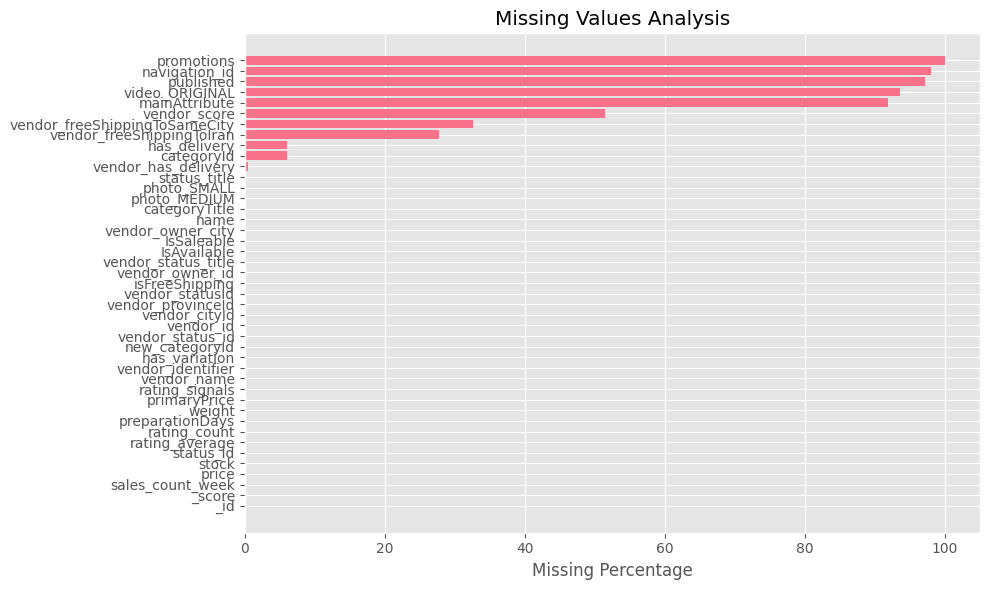

25/04/16 22:05:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



Detailed Missing Value Analysis:
                           Column  Missing Count  Missing Percentage
42                     promotions        2411289           99.997139
20                  navigation_id        2363132           98.000048
40                      published        2341306           97.094915
41                 video_ORIGINAL        2254969           93.514484
38                  mainAttribute        2213550           91.796822
29                   vendor_score        1239540           51.404229
25  vendor_freeShippingToSameCity         786896           32.632898
24      vendor_freeShippingToIran         669330           27.757388
17                   has_delivery         146166            6.061564
16                     categoryId         146163            6.061439
28            vendor_has_delivery          10409            0.431665
6                    status_title           2585            0.107201
8                    photo_MEDIUM            540            0.022394


In [7]:
import pandas as pd
# Analyze missing values
plot_missing_values(df)

# Get detailed missing value statistics
missing_stats = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
missing_stats = missing_stats.T.reset_index()
missing_stats.columns = ['Column', 'Missing Count']
missing_stats['Missing Percentage'] = (missing_stats['Missing Count'] / df.count()) * 100
missing_stats = missing_stats.sort_values('Missing Percentage', ascending=False)

print("\nDetailed Missing Value Analysis:")
print(missing_stats[missing_stats['Missing Percentage'] > 0])

## 2. Descriptive Statistics

In [8]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType, StringType, BooleanType, IntegerType

# Assuming `df` is your DataFrame
df_schema = df.dtypes

# Lists to hold the column names
numerical_columns = []
categorical_columns = []
binary_columns = []

# Loop through the schema and classify the columns
for column, dtype in df_schema:
    if isinstance(df.schema[column].dataType, NumericType):
        numerical_columns.append(column)
    elif isinstance(df.schema[column].dataType, StringType):
        categorical_columns.append(column)
    elif isinstance(df.schema[column].dataType, BooleanType):
        binary_columns.append(column)

# Show the results
print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)
print("Binary Columns:", binary_columns)

Numerical Columns: ['_id', '_score', 'sales_count_week', 'price', 'status_id', 'stock', 'rating_average', 'rating_count', 'rating_signals', 'primaryPrice', 'preparationDays', 'weight', 'categoryId', 'new_categoryId', 'navigation_id', 'vendor_statusId', 'vendor_freeShippingToIran', 'vendor_freeShippingToSameCity', 'vendor_cityId', 'vendor_provinceId', 'vendor_score', 'vendor_id', 'vendor_status_id', 'vendor_owner_id']
Categorical Columns: ['name', 'status_title', 'photo_MEDIUM', 'photo_SMALL', 'vendor_name', 'vendor_identifier', 'vendor_status_title', 'vendor_owner_city', 'mainAttribute', 'categoryTitle', 'video_ORIGINAL', 'promotions']
Binary Columns: ['has_delivery', 'has_variation', 'vendor_has_delivery', 'isFreeShipping', 'IsAvailable', 'IsSaleable', 'published']


In [ ]:
# Calculate descriptive statistics for numerical features
numeric_stats = df.select(numerical_columns).describe().toPandas()
print("Numerical Features Statistics:")
display(numeric_stats)

# Display distribution plots for numerical features
numerical_data = df.select(numerical_columns).toPandas()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_columns):
    if idx < len(axes):
        sns.histplot(data=numerical_data, x=col, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Numerical Features Statistics:


,summary,_id,_score,sales_count_week,price,status_id,stock,rating_average,rating_count,rating_signals,...,navigation_id,vendor_statusId,vendor_freeShippingToIran,vendor_freeShippingToSameCity,vendor_cityId,vendor_provinceId,vendor_score,vendor_id,vendor_status_id,vendor_owner_id
0,count,2411358,2411358,2411358,2411356,2411356,2411356,2411355,2411355,2411355,...,48226,2411355,1742028,1624462,2411355,2411355,1171818,2411355,2411355,2411355
1,mean,8597589.141956525,69.34688429883539,0.043767868562030195,9263276.288979728,2976.8719417622283,32907.0406592805,1.4855676994884555,1.8926437625318544,1.8926437625318544,...,319.3239124123917,2987.000376137068,1.8928645567940928E7,1.200753992478556E7,2221.1026609520372,13.971001366451642,0.4525916140561077,505573.3472533078,2987.000376137068,6273908.150367324
2,stddev,3402083.73473064,94.1673091389762,0.3214209540235807,3.438397326028527E7,26.627065291595756,4933175.676261697,2.1954467852079502,15.00858522542236,15.00858522542236,...,879.9023492307176,0.019390609711578684,6.3413044437709644E7,4.8504848830031075E7,321.5811094740018,7.813284836195351,0.49774758298567345,263082.1987844294,0.019390609711578684,4589965.069693647
3,min,20276,0.0,0,10000,2976,0,0.0,0,0,...,1,2987,0,0,1722,3,0,7,2987,11
4,max,13445061,491.3793,56,999999990,3790,1000000000,5.0,4488,4488,...,9982,2988,999999990,999999990,2967,33,1,967729,2988,15825531


## 3. Sales Analysis

In [ ]:
# Analyze relationship between sales, stock, and price
sales_analysis = df.select('sales_count_week', 'stock', 'price', 'primaryPrice').toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Sales vs Stock
sns.scatterplot(data=sales_analysis, x='stock', y='sales_count_week', ax=axes[0,0], alpha=0.5)
axes[0,0].set_title('Sales vs Stock')

# Sales vs Price
sns.scatterplot(data=sales_analysis, x='price', y='sales_count_week', ax=axes[0,1], alpha=0.5)
axes[0,1].set_title('Sales vs Price')

# Sales vs Primary Price
sns.scatterplot(data=sales_analysis, x='primaryPrice', y='sales_count_week', ax=axes[1,0], alpha=0.5)
axes[1,0].set_title('Sales vs Primary Price')

# Price Discount Analysis
sales_analysis['discount_percentage'] = ((sales_analysis['primaryPrice'] - sales_analysis['price']) 
                                        / sales_analysis['primaryPrice'] * 100)
sns.scatterplot(data=sales_analysis, x='discount_percentage', y='sales_count_week', ax=axes[1,1], alpha=0.5)
axes[1,1].set_title('Sales vs Discount Percentage')

plt.tight_layout()
plt.show()

## 4. Category Analysis

In [ ]:
# Analyze sales by category
category_analysis = df.groupBy('categoryTitle').agg(
    F.avg('sales_count_week').alias('avg_sales'),
    F.count('*').alias('product_count'),
    F.avg('price').alias('avg_price'),
    F.avg('rating_average').alias('avg_rating')
).toPandas()

# Plot top categories by average sales
plt.figure(figsize=(15, 6))
top_categories = category_analysis.nlargest(10, 'avg_sales')
sns.barplot(data=top_categories, x='categoryTitle', y='avg_sales')
plt.xticks(rotation=45, ha='right')
plt.title('Average Weekly Sales by Top 10 Categories')
plt.tight_layout()
plt.show()

# Display category statistics
print("\nCategory Statistics:")
display(category_analysis.sort_values('avg_sales', ascending=False).head(10))

## 5. Shipping and Delivery Analysis

In [ ]:
# Analyze impact of free shipping and delivery options
shipping_features = ['isFreeShipping', 'has_delivery', 
                    'vendor_freeShippingToIran', 'vendor_freeShippingToSameCity']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(shipping_features):
    shipping_stats = df.groupBy(feature) \
        .agg(F.avg('sales_count_week').alias('avg_sales'),
             F.count('*').alias('count')) \
        .toPandas()
    
    sns.barplot(data=shipping_stats, x=feature, y='avg_sales', ax=axes[idx])
    axes[idx].set_title(f'Average Sales by {feature}')

plt.tight_layout()
plt.show()

## 6. Vendor Analysis

In [ ]:
# Analyze vendor performance
vendor_analysis = df.groupBy('vendor_name') \
    .agg(F.avg('sales_count_week').alias('avg_sales'),
         F.avg('rating_average').alias('avg_rating'),
         F.count('*').alias('product_count')) \
    .filter('product_count >= 10') \
    .toPandas()

# Plot vendor performance
plt.figure(figsize=(12, 8))
plt.scatter(vendor_analysis['avg_rating'], 
           vendor_analysis['avg_sales'],
           s=vendor_analysis['product_count'],
           alpha=0.6)
plt.xlabel('Average Rating')
plt.ylabel('Average Weekly Sales')
plt.title('Vendor Performance: Sales vs Ratings (size = product count)')

# Add annotations for top performers
top_vendors = vendor_analysis.nlargest(5, 'avg_sales')
for _, vendor in top_vendors.iterrows():
    plt.annotate(vendor['vendor_name'],
                 (vendor['avg_rating'], vendor['avg_sales']))

plt.tight_layout()
plt.show()

## 7. Correlation Analysis

In [ ]:
# Calculate and plot correlation matrix
plot_correlation_matrix(df, numerical_columns)

# Calculate detailed correlations with sales
correlations = []
for feature in numerical_columns:
    correlation = df.stat.corr('sales_count_week', feature)
    correlations.append({
        'feature': feature,
        'correlation': correlation
    })

correlations_df = pd.DataFrame(correlations)
correlations_df = correlations_df.sort_values('correlation', key=abs, ascending=False)

print("\nCorrelations with sales_count_week:")
display(correlations_df)

## 8. Outlier Detection

In [ ]:
# Create box plots for numerical features
plt.figure(figsize=(15, 6))
numerical_data.boxplot(column=numerical_columns, figsize=(15, 6))
plt.xticks(rotation=45)
plt.title('Box Plots of Numerical Features')
plt.tight_layout()
plt.show()

# Detect outliers using Z-score method
outlier_stats = {}
for feature in numerical_columns:
    df_with_outliers = detect_outliers(df, feature)
    outlier_count = df_with_outliers.filter(col(f'{feature}_is_outlier')).count()
    outlier_percentage = (outlier_count / df.count()) * 100
    outlier_stats[feature] = {
        'outlier_count': outlier_count,
        'outlier_percentage': outlier_percentage
    }

print("\nOutlier Statistics (|z-score| > 3):")
outlier_df = pd.DataFrame.from_dict(outlier_stats, orient='index')
display(outlier_df)

## 9. Key Insights Summary

Based on the analysis above, here are the key insights:

1. **Missing Data**:
   - [Will be filled based on actual analysis]

2. **Sales Patterns**:
   - Relationship between sales and stock levels
   - Impact of pricing on sales
   - Effect of discounts

3. **Category Performance**:
   - Top performing categories
   - Category-wise pricing strategies

4. **Shipping Impact**:
   - Effect of free shipping on sales
   - Delivery options influence

5. **Vendor Analysis**:
   - Top performing vendors
   - Relationship between ratings and sales

6. **Correlations**:
   - Strong predictors of sales
   - Feature relationships

7. **Outliers**:
   - Distribution of extreme values
   - Impact on modeling strategy